In [138]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.plot as uplot
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
from UMAP import *
pd.options.mode.use_inf_as_na = True

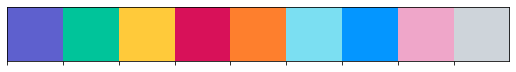

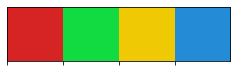

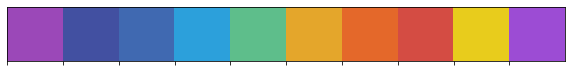

In [139]:

CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.612,	0.3 , 0.834]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [177]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,norm=True, c_list=None ,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d_exc = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d_exc[:, 0],
             'UMAP2':clusterable_embedding2d_exc[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])

    # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
    sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

    # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
    ax12d.legend()
    if save:
        plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
    
    plt.show()

    return labels_exc,mapper,reducer

In [141]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]

In [154]:

features_ext = ['current_at_first_spike','ap_count','fr','inst_fr','time_to_first_spike','mean_isi','median_isi','max_isi',
'min_isi','first_thr','mean_thr','median_thr','min_thr','max_thr','mean_width','median_width','max_width',
'min_width','mean_amplitude','median_amplitude','min_amplitude','max_amplitude','exp_name','cond','trialnr']
features_ext_sub = ['current_at_first_spike','ap_count','fr','inst_fr','time_to_first_spike','mean_isi','median_isi','max_isi',
'min_isi','first_thr','mean_thr','median_thr','min_thr','max_thr','mean_width','median_width','max_width',
'min_width','mean_amplitude','median_amplitude','min_amplitude','max_amplitude']
data_all_conds = pickle.load(open('G:/My Drive/Cluster Feature files/Niccolo_FN.pkl','rb'))
exc = data_all_conds['exc']
inh = data_all_conds['inh']
def lower(data):
    return data.lower()
exc_df_all = pd.DataFrame(exc,columns = features_ext)
inh_df_all = pd.DataFrame(inh,columns = features_ext)
exc_inh_df = pd.concat([exc_df_all,inh_df_all])
exc_inh_df.index = np.arange(len(exc_inh_df))
inds =set(np.where(exc_inh_df.isna())[0])

exc_inh_df['ei_labels'] = np.concatenate((np.repeat(0,len(exc_df_all)),np.repeat(1,len(inh_df_all))))
exc_inh_df = exc_inh_df.drop(inds,axis=0)

exc_inh_df.cond = exc_inh_df.cond.apply(lower)    
exc_inh_df_acsf = exc_inh_df[exc_inh_df.cond=='acsf'] 
NC_data  = exc_inh_df_acsf[ exc_inh_df_acsf.exp_name.isin(exc_inh_df_acsf.exp_name[['NC' in i for i in exc_inh_df_acsf.exp_name]])]
NC_data1= NC_data[NC_data.trialnr==1]
NC_data1 = NC_data1.drop_duplicates('exp_name')
np.shape(NC_data1)

(117, 26)

In [155]:
NC_data1

,current_at_first_spike,ap_count,fr,inst_fr,time_to_first_spike,mean_isi,median_isi,max_isi,min_isi,first_thr,...,max_width,min_width,mean_amplitude,median_amplitude,min_amplitude,max_amplitude,exp_name,cond,trialnr,ei_labels
0,8.200875,291,0.887500,0.046849,2703.35,1224.064483,274.250,15331.60,6.45,-44.218749,...,0.975,0.075,84.861815,90.718750,51.062500,132.343750,NC_170711_aCSF_D1ago_E1,acsf,1,0
4,196.910798,127,0.383333,0.005651,8316.55,2772.755159,1818.250,15337.05,15.15,-36.125001,...,0.950,0.575,84.804981,86.218748,56.250000,103.874996,NC_170712_aCSF_D1ago_E1,acsf,1,0
5,136.330819,171,1.870000,0.032204,2101.80,2103.784412,1570.900,16483.80,4.10,-27.500000,...,1.450,0.125,66.987582,70.656250,4.750000,115.999997,NC_170712_aCSF_D1ago_E2,acsf,1,0
8,159.948951,208,0.623333,0.005363,2114.20,1717.713285,1007.400,15333.75,11.20,-38.249999,...,0.800,0.600,83.333732,84.343750,24.406250,90.500001,NC_170713_aCSF_DopD2D1_E3,acsf,1,0
9,17.677462,1381,4.370000,0.025703,183.20,260.546667,139.400,2634.55,6.60,-39.781250,...,0.750,0.375,74.431095,78.874999,8.281250,100.812502,NC_170713_aCSF_DopD2D1_E4,acsf,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,123.285052,4619,12.833333,0.035120,170.10,77.916457,41.150,965.40,4.70,-52.156251,...,0.275,0.075,60.407508,61.125000,32.906250,87.125000,NC_170816_aCSF_D1ago_E2,acsf,1,1
662,24.600246,6847,21.969444,0.061697,148.70,52.560795,32.075,548.50,3.95,-44.812500,...,0.650,0.100,92.920669,100.249998,2.406249,139.843747,NC_170830_aCSF_D1ago_E6,acsf,1,1
664,151.247567,1260,3.500000,0.021509,174.35,285.790667,148.250,2502.45,5.15,-41.749999,...,0.225,0.200,84.138839,84.156249,67.343751,100.000001,NC_170914_aCSF_D1ago_E1,acsf,1,1
692,156.268867,1942,5.877778,0.024512,173.60,185.372257,98.150,1644.75,5.95,-29.531250,...,0.475,0.100,60.904050,61.500001,37.968749,86.906251,NC_171211_aCSF_E1,acsf,1,1


In [156]:
def return_name_string_obj_NC(data):
  broken_str = data.split('_')
  if 'NC' == broken_str[2]:
    name = broken_str[2]
    date = broken_str[3]
    return name+'_'+date
  else:
    name = broken_str[3]
    date = broken_str[2]
    return name+'_'+date

def modify_names(file_name):
  str_temp = file_name
  all_parts = str_temp.split('_')
  print(all_parts)
  name = all_parts[0]
  if 'Payam' == name:
    name = name.lower()
  broken = all_parts[1].split('-')
  date = broken[:3]
  date = date[0]+date[1]+date[2]
  exp = broken[3]
  return name+'_'+date+'_'+exp

def return_name_date_exp_fn(string):

  if 'NC' in string:
    string_broken = string.split('_')
    name = string_broken[0]
    date = string_broken[1]
    exp = string_broken[-1]
    year = date[:2]
    month = date[2:4]

    if month[0] =='0':
      month = month[1]
    day = date[4:]
    if day[0] =='0':
      day = day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp 
  elif 'xuan' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'asli' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp    
  elif 'Payam' in string:
    broken_str = string.split('_')
    name = broken_str[0].lower()
    date = broken_str[1].split('-')
    exp =  broken_str[2]
    day = date[0]
    month = date[1]
    year = date[2]
    if day[0] =='0':
      day=day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp

all_cc_names_and_dates = [return_name_date_exp_fn(i) for i in exc_inh_df_acsf.exp_name]

# modify_names(exc_inh_df_acsf.exp_name[0])  

In [157]:
exc_inh_df_acsf.exp_name = exc_inh_df_acsf.exp_name.apply(return_name_date_exp_fn)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [158]:
exc_inh_df_acsf

,current_at_first_spike,ap_count,fr,inst_fr,time_to_first_spike,mean_isi,median_isi,max_isi,min_isi,first_thr,...,max_width,min_width,mean_amplitude,median_amplitude,min_amplitude,max_amplitude,exp_name,cond,trialnr,ei_labels
0,8.200875,291,0.887500,0.046849,2703.35,1224.064483,274.25,15331.60,6.45,-44.218749,...,0.975,0.075,84.861815,90.718750,51.062500,132.343750,NC_11717_E1,acsf,1,0
1,239.102574,177,0.590000,0.037377,2698.60,2010.438920,772.70,18273.45,6.30,-39.593749,...,0.925,0.450,83.459774,89.343748,51.187498,98.468751,NC_11717_E1,acsf,2,0
2,144.071654,433,1.560000,0.014939,1819.10,825.283449,477.60,6183.95,7.60,-40.937498,...,0.725,0.425,86.679612,89.062499,33.812500,112.124998,NC_11717_E2,acsf,2,0
4,196.910798,127,0.383333,0.005651,8316.55,2772.755159,1818.25,15337.05,15.15,-36.125001,...,0.950,0.575,84.804981,86.218748,56.250000,103.874996,NC_12717_E1,acsf,1,0
5,136.330819,171,1.870000,0.032204,2101.80,2103.784412,1570.90,16483.80,4.10,-27.500000,...,1.450,0.125,66.987582,70.656250,4.750000,115.999997,NC_12717_E2,acsf,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,159.357426,6183,17.227778,0.059214,170.65,58.203551,21.80,956.15,4.55,-46.093751,...,0.325,0.225,86.039846,90.390626,33.093750,146.499999,xuan_9519_E1,acsf,1,1
875,210.442570,430,1.194444,0.007305,1901.25,834.697319,552.20,5152.95,8.40,-42.624999,...,0.250,0.150,101.515770,101.093749,80.781251,111.906253,xuan_9519_E3,acsf,1,1
877,251.319290,3260,9.111111,0.044225,173.50,110.405769,37.80,1586.60,5.10,-30.062500,...,0.400,0.250,78.526038,83.500000,27.531249,137.281250,xuan_9919_E1,acsf,1,1
880,24.907842,864,2.402778,0.016246,1563.10,415.320568,228.40,3302.75,4.95,-43.218751,...,0.225,0.150,108.289632,108.562503,83.281249,144.468747,xuan_9919_E3,acsf,1,1


In [181]:
# data = pd.read_csv('G:/My Drive/NC_new_CC.csv')
data = pd.read_csv("C:/Users/Nishant Joshi/Downloads/CC_exps_clust.csv")
feats  = data.columns[1:]

data =  data[feats]
data_inh = data[data.classification=='inhibitory']
data_exc = data[data.classification=='excitatory']


Create DF for FN and CC files

In [200]:
fn_cc_df = exc_inh_df_acsf[exc_inh_df_acsf.exp_name.isin(set(data['exp_name']))]
fn_cc_df = fn_cc_df[fn_cc_df.trialnr==1]

data_CC_FN = data[data.exp_name.isin(data['exp_name'])]
data_CC_FN = data_CC_FN[data_CC_FN.trial==0] 
data_inh = data_CC_FN[data_CC_FN.classification=='inhibitory']
data_exc = data_CC_FN[data_CC_FN.classification=='excitatory']

print(len(fn_cc_df))
print(len(data_CC_FN))


103
105


Plot UMAP for all CC files shared on Monday (07/09/23)

13


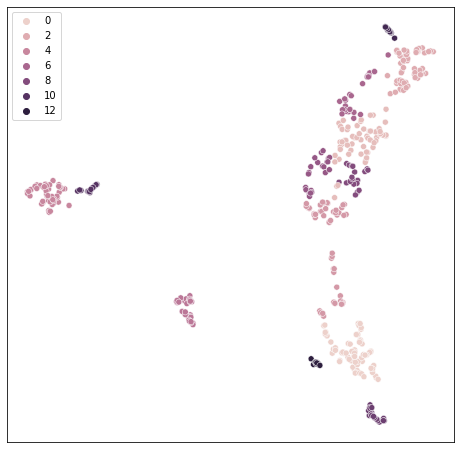

In [204]:
data_NC_new = pd.read_csv('G:/My Drive/NC_new_CC.csv')
feats = data_NC_new.columns

data_NC_new =  data_NC_new[feats]


NC_all_CC = data_NC_new[data_NC_new.columns[:-2]] 
labels_wave_exc_fn,mapper,reducer = plot_UMAP_clusters_single(NC_exc_CC,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list = np.repeat('red',400),
                          )


4


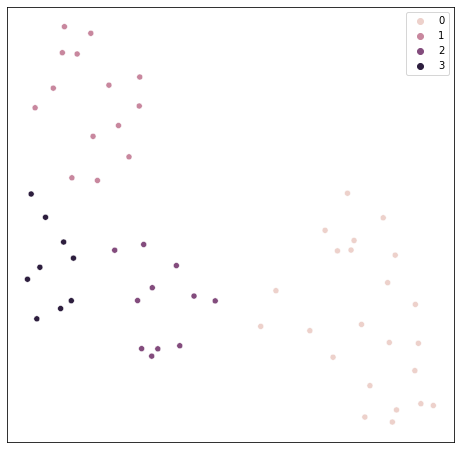

4


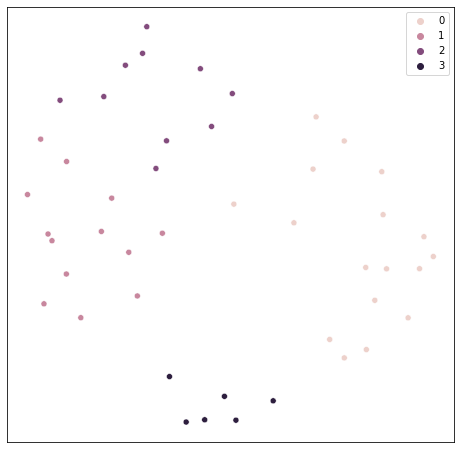

35
82


In [205]:
NC_FN_all  = fn_cc_df # NC_data1[features_ext_sub]
NC_FN_all_exc = NC_FN_all[NC_FN_all.ei_labels==0]
NC_FN_all_inh = NC_FN_all[NC_FN_all.ei_labels==1]

labels_wave_exc_fn,mapper,reducer = plot_UMAP_clusters_single(NC_FN_all_exc[NC_FN_all_exc.columns[:-4]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1,
                          c_list =coherence_colors,
                          )

labels_wave_inh_fn,mapper,reducer = plot_UMAP_clusters_single(NC_FN_all_inh[NC_FN_all_inh.columns[:-4]],
                          15,
                          0.1,
                          random_state =42,
                          res_louvain = 1,
                          c_list =coherence_colors,
                          )                          

print(len(NC_data1[features_ext_sub][NC_data1.ei_labels == 1]))

print(len(NC_data1[features_ext_sub][NC_data1.ei_labels == 0]))

In [198]:
print(np.unique(labels_wave_exc,return_counts=True))
print(np.unique(labels_wave_inh,return_counts=True))
# umap.plot.points(mapper, labels=labels_wave_inh, theme='fire')


(array([0, 1, 2, 3], dtype=int64), array([15, 15, 14, 13], dtype=int64))
(array([0, 1, 2, 3], dtype=int64), array([17, 10, 10,  9], dtype=int64))


5


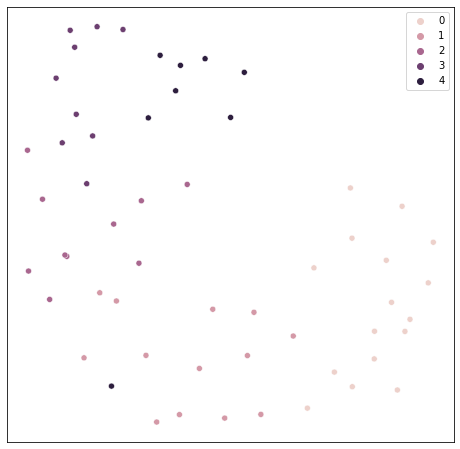

4


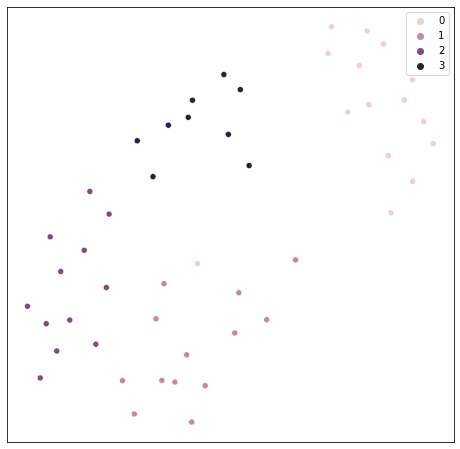

49
56


In [207]:

NC_exc_CC = data_exc[data_exc.columns[:-5]]
NC_inh_CC = data_inh[data_inh.columns[:-5]]
NC_all_CC= data_CC_FN[data_CC_FN.columns[:-5]]
labels_wave_exc_CC,mapper_cc_exc,reducer = plot_UMAP_clusters_single(NC_exc_CC,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1,
                          c_list =coherence_colors,
                          )

labels_wave_inh_CC,mapper_cc_inh,reducer = plot_UMAP_clusters_single(NC_inh_CC,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1,
                          c_list =coherence_colors,
                          )                          

print(len(data_inh))

print(len(data_exc))

In [208]:
print(np.unique(labels_wave_exc_CC,return_counts=True))
print(np.unique(labels_wave_inh_CC,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int64), array([16, 13, 10,  9,  8], dtype=int64))
(array([0, 1, 2, 3], dtype=int64), array([15, 13, 12,  9], dtype=int64))


In [24]:
data_cc_tr1 = data[data.trial==0]
data_cc_tr1  = data_cc_tr1.assign(labels = np.nan) 
data_cc_tr1_exc = data_cc_tr1[data_cc_tr1.classification=='excitatory'] 
data_cc_tr1_inh = data_cc_tr1[data_cc_tr1.classification=='inhibitory'] 
data_cc_tr1_exc =data_cc_tr1_exc.assign(labels= labels_wave_exc_CC)
data_cc_tr1_inh =data_cc_tr1_inh.assign(labels= labels_wave_inh_CC) 


In [ ]:
uplot.points(mapper_cc_inh,cmap='BrBG_r',theme='blue')
uplot.points(mapper_FN_inh,cmap='BrBG_r',theme='blue')


In [47]:
cells,features = waves_inh_FN.shape
pca = PCA(n_components=features)
scaler = StandardScaler()
data_all = waves_inh_FN
data_all = scaler.fit_transform(data_all)
data_all = normalize(data_all)
pca.fit(data_all)
eigenvalues = pca.explained_variance_
sum(eigenvalues)**2/sum(eigenvalues**2)

3.7162097674066272

Manifold alignment between all FN and CC cells (new data)

use random seed: 666
Shape of Raw data
Dataset 0: (105, 24)
Dataset 1: (103, 22)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:0.3416 alpha:0.7539
epoch:[200/2000] err:0.3610 alpha:0.8053
epoch:[300/2000] err:0.3611 alpha:0.8163
epoch:[400/2000] err:0.3588 alpha:0.8238
epoch:[500/2000] err:0.3554 alpha:0.8298
epoch:[600/2000] err:0.3517 alpha:0.8352
epoch:[700/2000] err:0.3480 alpha:0.8403
epoch:[800/2000] err:0.3445 alpha:0.8451
epoch:[900/2000] err:0.3413 alpha:0.8496
epoch:[1000/2000] err:0.3384 alpha:0.8538
epoch:[1100/2000] err:0.3359 alpha:0.8578
epoch:[1200/2000] err:0.3337 alpha:0.8614
epoch:[1300/2000] err:0.3318 alpha:0.8648
epoch:[1400/2000] err:0.3301 alpha:0.8679
epoch:[1500/2000] err:0.3286 alpha:0.8708
epoch:[1600/2000] err:0.3273 alpha:0.8734
epoch:[1700/2000] err:0.3261 alpha:0.8759
epoch:[1800/2000] err:0.3247 alpha:0.8783
epoch:[1900/2000] err:0.3230 alpha:0.8807
epoch:[2000/2000] err:0.3206

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


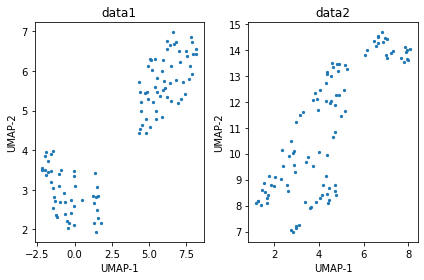

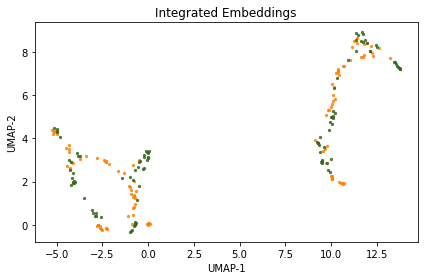

In [218]:

from unioncom import UnionCom
# import numpy as np
data1= NC_all_CC
data_scaler = StandardScaler()
data1 = data_scaler.fit_transform(data1)

data2 = NC_FN_all[NC_FN_all.columns[:-4]]
data2 = data_scaler.fit_transform(data2)
uc = UnionCom.UnionCom(project_mode='tsne')
integrated_data = uc.fit_transform(dataset=[data1,data2])

uc.Visualize([data1,data2], integrated_data, mode='UMAP') # without datatype


use random seed: 666
Shape of Raw data
Dataset 0: (105, 24)
Dataset 1: (103, 22)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:0.3416 alpha:0.7539
epoch:[200/2000] err:0.3610 alpha:0.8053
epoch:[300/2000] err:0.3611 alpha:0.8163
epoch:[400/2000] err:0.3588 alpha:0.8238
epoch:[500/2000] err:0.3554 alpha:0.8298
epoch:[600/2000] err:0.3517 alpha:0.8352
epoch:[700/2000] err:0.3480 alpha:0.8403
epoch:[800/2000] err:0.3445 alpha:0.8451
epoch:[900/2000] err:0.3413 alpha:0.8496
epoch:[1000/2000] err:0.3384 alpha:0.8538
epoch:[1100/2000] err:0.3359 alpha:0.8578
epoch:[1200/2000] err:0.3337 alpha:0.8614
epoch:[1300/2000] err:0.3318 alpha:0.8648
epoch:[1400/2000] err:0.3301 alpha:0.8679
epoch:[1500/2000] err:0.3286 alpha:0.8708
epoch:[1600/2000] err:0.3273 alpha:0.8734
epoch:[1700/2000] err:0.3261 alpha:0.8759
epoch:[1800/2000] err:0.3247 alpha:0.8783
epoch:[1900/2000] err:0.3230 alpha:0.8807
epoch:[2000/2000] err:0.3206

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


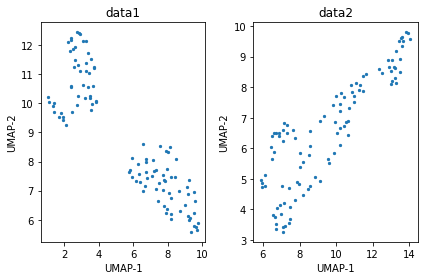

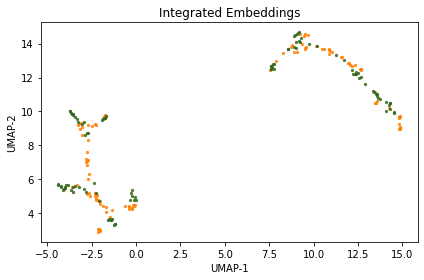

use random seed: 666
Shape of Raw data
Dataset 0: (105, 24)
Dataset 1: (103, 22)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:0.3416 alpha:0.7539
epoch:[200/2000] err:0.3610 alpha:0.8053
epoch:[300/2000] err:0.3611 alpha:0.8163
epoch:[400/2000] err:0.3588 alpha:0.8238
epoch:[500/2000] err:0.3554 alpha:0.8298
epoch:[600/2000] err:0.3517 alpha:0.8352
epoch:[700/2000] err:0.3480 alpha:0.8403
epoch:[800/2000] err:0.3445 alpha:0.8451
epoch:[900/2000] err:0.3413 alpha:0.8496
epoch:[1000/2000] err:0.3384 alpha:0.8538
epoch:[1100/2000] err:0.3359 alpha:0.8578
epoch:[1200/2000] err:0.3337 alpha:0.8614
epoch:[1300/2000] err:0.3318 alpha:0.8648
epoch:[1400/2000] err:0.3301 alpha:0.8679
epoch:[1500/2000] err:0.3286 alpha:0.8708
epoch:[1600/2000] err:0.3273 alpha:0.8734
epoch:[1700/2000] err:0.3261 alpha:0.8759
epoch:[1800/2000] err:0.3247 alpha:0.8783
epoch:[1900/2000] err:0.3230 alpha:0.8807
epoch:[2000/2000] err:0.3206

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


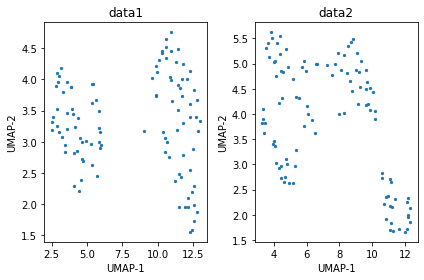

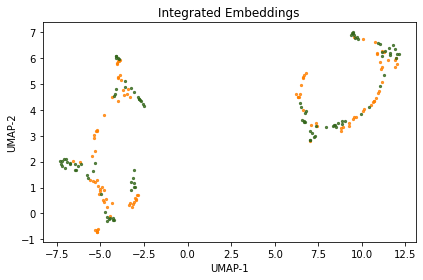

In [214]:
from unioncom import UnionCom
# import numpy as np
data_scaler = StandardScaler()
data1_exc= NC_FN_all_exc
data1_exc = data_scaler.fit_transform(data1)

data2_exc = NC_exc_CC 
data2_exc = data_scaler.fit_transform(data2)


data1_inh= NC_FN_all_inh
data1_inh = data_scaler.fit_transform(data1)

data2_inh = NC_inh_CC
data2_inh = data_scaler.fit_transform(data2)


uc = UnionCom.UnionCom()
integrated_data = uc.fit_transform(dataset=[data1_exc,data2_exc])

uc.Visualize([data1,data2], integrated_data, mode='UMAP') # without datatype

plt.show()

uc = UnionCom.UnionCom()
integrated_data = uc.fit_transform(dataset=[data1_inh,data2_inh])

uc.Visualize([data1_inh,data2_inh], integrated_data, mode='UMAP') # without datatype

In [130]:
import os
import random
import numpy as np
import scipy.sparse as sp 
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

def align_fraction(data1, data2):
	row1, col1 = np.shape(data1)
	row2, col2 = np.shape(data2)
	fraction = 0
	for i in range(row1):
		count = 0
		diffMat = np.tile(data1[i], (row2,1)) - data2
		sqDiffMat = diffMat**2
		sqDistances = sqDiffMat.sum(axis=1)
		for j in range(row2):
			if sqDistances[j] < sqDistances[i]:
				count += 1
		fraction += count / row2

	return fraction / row1

def transfer_accuracy(domain1, domain2, type1, type2):
	knn = KNeighborsClassifier()
	knn.fit(domain2, type2)
	type1_predict = knn.predict(domain1)
	np.savetxt("type1_predict.txt", type1_predict)
	count = 0
	for label1, label2 in zip(type1_predict, type1):
		if label1 == label2:
			count += 1
	return count / len(type1)

def test_UnionCom(integrated_data, datatype):

	for i in range(len(integrated_data)-1):
		# fraction = align_fraction(data[i], data[-1])
		# print("average fraction:")
		# print(fraction)

		acc = transfer_accuracy(integrated_data[i], integrated_data[-1], datatype[i], datatype[-1])
		print("label transfer accuracy of data{:d}:".format(i+1))
		print(acc)
test_UnionCom(integrated_data, [data1,data2])

ValueError: Unknown label type: 'continuous-multioutput'

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\unioncom\visualization.py:127: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding[i][:,0], embedding[i][:,1], c=color[i], s=5., alpha=0.8)


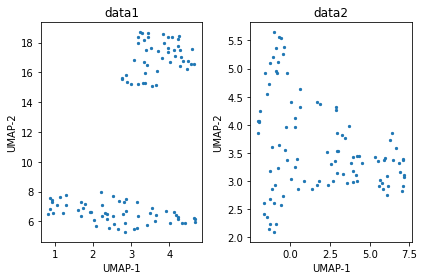

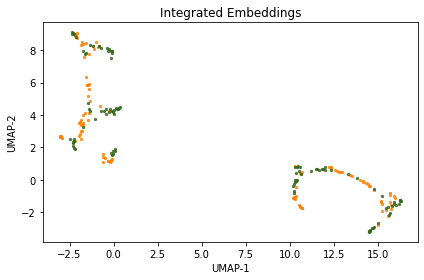

In [212]:
# uc.test_LabelTA(integrated_data, [labels_wave_inh_CC,labels_wave_inh_FN])
uc.Visualize([data1,data2], integrated_data, mode='UMAP') # without datatype
# uc.Visualize([waves_exc_CC,waves_exc_FN], integrated_data, mode='UMAP') 
# uc.Visualize([data1,data2], integrated_data, [np.int32,np.int32], mode='PCA') # with datatype

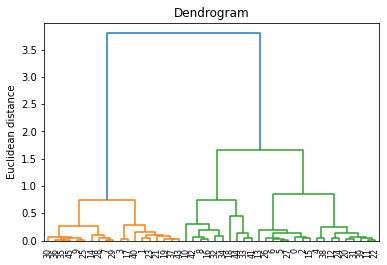

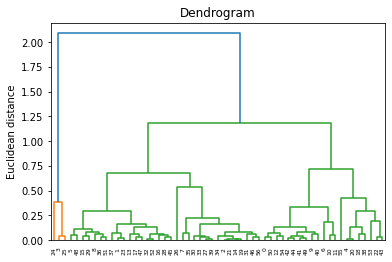

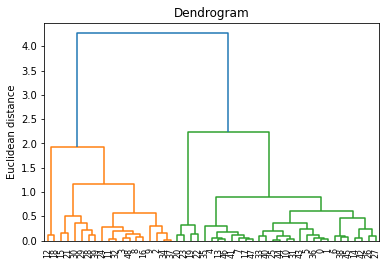

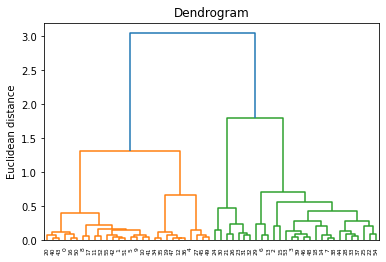

In [26]:
#Importing libraries
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram , linkage
 
#Getting the data ready


#Linkage Matrix
def plot_dendro(data):
    Z = linkage(data, method = 'ward')
 
    #plotting dendrogram
    dendro = dendrogram(Z)
    plt.title('Dendrogram')
    plt.ylabel('Euclidean distance')
    plt.show()
plot_dendro(waves_inh_FN)   
plot_dendro(waves_exc_FN)   

plot_dendro(waves_inh_CC)   
plot_dendro(waves_exc_CC)   


In [ ]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = df_waves_acsf['waveforms']
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.vstack(np.random.permutation(full_data))
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))

f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

In [ ]:
# data_umap = exc_inh_df[features_ext_sub][exc_inh_df.ei_labels == 0]
data_umap = waves_all
cells,features = data_umap.shape
pca = PCA(n_components=features)
scaler = StandardScaler()
data_all = data_umap
data_all = scaler.fit_transform(data_all)
data_all = normalize(data_all)
pca.fit(data_all)
eigenvalues = pca.explained_variance_
sum(eigenvalues)**2/sum(eigenvalues**2)

In [ ]:
sns.histplot(exc_df_acsf['labels_lv']+1,discrete=True)
sns.histplot(exc_df_acsf['labels_lv']+1,discrete=True)


In [ ]:
plt.scatter(np.arange(len(eigenvalues)),eigenvalues)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(data,feat):
    
    testSize = 0.3;
    RAND_STATE = 20
    UMAP_X = np.stack(data[feat].to_numpy().tolist(), axis=0)
    UMAP_y = data['labels_lv'].to_numpy()

    unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

    UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
    UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

    UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND_STATE)


    numCV = 5

    UMAP_model = xgb.XGBClassifier()
    UMAP_param_dist = {"max_depth": [4],
                "min_child_weight" : [2.5],
                "n_estimators": [100],
                "learning_rate": [0.3],
                "seed": [RAND_STATE]}
    UMAP_grid_search = GridSearchCV(UMAP_model, param_grid=UMAP_param_dist, 
                            cv = numCV, 
                            verbose=10, n_jobs=-1)
    UMAP_grid_search.fit(UMAP_X_train, UMAP_y_train)

    return  confusion_matrix(UMAP_y_test,UMAP_grid_search.predict(UMAP_X_test))


In [ ]:
def plot_confusion_matrix(conf_matrix,labels):
    confusion_mat_counts = conf_matrix
    N_CLUST = len(set(labels))
    conf_mat_row_list = []
    for row in confusion_mat_counts:
        row_sum = np.sum(row)
        
        row_percent = []
        
        for val in row:
            row_percent.append(val/row_sum)
        
        conf_mat_row_list.append(row_percent)

    conf_mat = np.array(conf_mat_row_list)

    colormap = mpl.cm.YlGnBu
    colormap.set_under('white')

    eps = np.spacing(0.0)
    f, arr = plt.subplots(1,figsize=[4,3])
    mappable = arr.imshow(conf_mat,cmap=colormap,vmin=eps,vmax=1.)
    color_bar = f.colorbar(mappable, ax=arr, extend='min')
    color_bar.set_label('P (Predicted | True)',fontsize=12,labelpad=15,fontname="Arial")
    color_bar.ax.tick_params(size=3,labelsize=12)

    #Specify label behavior of the main diagonal
    for i in range(0,N_CLUST):
        if int(conf_mat[i,i]*100) == 100:
            arr.text(i-0.38,i+0.17,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
        else:
            arr.text(i-0.34,i+0.16,int(round(conf_mat[i,i]*100)),fontsize=10,c='white',fontname="Arial")
            
    #Specify label behavior of the off-diagonals
    for i in range(0,N_CLUST):
        for j in range(0,N_CLUST):
            if conf_mat[i,j] < 0.1 and conf_mat[i,j] != 0:
                arr.text(j-0.2,i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")
            elif conf_mat[i,j] >= 0.1 and conf_mat[i,j] < 0.5 and conf_mat[i,j] != 0:
                arr.text(j-0.4, i+0.15,int(round(conf_mat[i,j]*100)),fontsize=10,c='k',fontname="Arial")

    arr.set_xticks(range(0,N_CLUST))
    arr.set_xticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_yticks(range(0,N_CLUST))
    arr.set_yticklabels(range(1,N_CLUST+1),fontsize=12);
    arr.set_xlabel('Predicted Class',fontsize=12);
    arr.set_ylabel('True Class',fontsize=12);
    plt.tight_layout()

plot_confusion_matrix(get_confusion_matrix(inh_df_acsf,feat[:-1]),labels_inh)    

In [ ]:
exc_df_acsf['labels_lv'] = labels_exc

plot_confusion_matrix(get_confusion_matrix(exc_df_acsf,feat[:-1]),labels_exc)    

In [ ]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = join_wave_with_ephys(feat, exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==0])
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))

f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

In [ ]:
testSize = 0.3;

UMAP_X = np.stack(umap_df['waveform'].to_numpy().tolist(), axis=0)
UMAP_y = umap_df['color'].to_numpy()

unclassified_ixs = [ix for ix,clust in enumerate(UMAP_y) if clust == -1]

UMAP_X = np.delete(UMAP_X,unclassified_ixs,axis=0)
UMAP_y = np.delete(UMAP_y,unclassified_ixs,axis=0)

UMAP_X_train, UMAP_X_test, UMAP_y_train, UMAP_y_test = train_test_split(UMAP_X, UMAP_y, test_size=testSize, random_state=RAND)



In [ ]:
resolution_list = np.linspace(0,5,11)
modularity_dict = {}
n_clusts_dict = {}
#Louvain Clustering Parameters
RESOLUTION = 1.5
random_state = 42
full_data = join_wave_with_ephys(feat, exc_inh_df_w_waves_acsf[exc_inh_df_w_waves_acsf['ephys_labels']==1])
# BLUE COLOR
BlueCol = '\033[94m'
subsets=[100]
import random 
for res in resolution_list:
    print("\n" + BlueCol + str(res))
    for frac in subsets:
        rand_list = []
        n_clusts = []
        for i in list(range(1,25)):
            reducer_rand_test = umap.UMAP(n_neighbors = 20, 
                                     min_dist=0.0, 
                                     random_state=random.randint(1,100000))
            rand_data = np.random.permutation(full_data)[0:(int(len(full_data)*frac)),:]
            mapper = reducer_rand_test.fit(rand_data)
            embedding_rand_test = reducer_rand_test.transform(rand_data)

            umap_df_rand_test = pd.DataFrame(embedding_rand_test, columns=('x', 'y'))
            louvain = Louvain(resolution=res,random_state=random_state)
            adjacency = mapper.graph_
            labels_exc = louvain.fit_predict(adjacency)
            clustering_solution = labels_exc
            modularity= get_modularity(adjacency,labels_exc)
            rand_list.append(modularity)
            n_clusts.append(len(set(clustering_solution)))
        modularity_dict.update({str(res): rand_list})
        n_clusts_dict.update({str(res): n_clusts})


resolution_list = np.linspace(0,5,11)

if 'n_clusts_dict' not in list(locals().keys()):
  n_clusts_dict = pkl.load(open('WaveMAP_Paper/data/n_clusts_dict.pkl','rb'))

if 'modularity_dict' not in list(locals().keys()):
  modularity_dict = pkl.load(open('WaveMAP_Paper/data/modularity_dict.pkl','rb'))

avg_n_clusts = []
for k in list(n_clusts_dict.keys()):
    avg_n_clusts.append(np.mean(n_clusts_dict[k]))
    
std_n_clusts = []
for k in list(n_clusts_dict.keys()):
    std_n_clusts.append(np.std(n_clusts_dict[k]))
    
std_modularity = []
for k in list(modularity_dict.keys()):
    std_modularity.append(np.std(modularity_dict[k]))
    
avg_modularity = []
for k in list(modularity_dict.keys()):
    avg_modularity.append(np.mean(modularity_dict[k]))



In [ ]:
f, ax1 = plt.subplots(figsize=[3,2.5])

ax1.errorbar(resolution_list,avg_modularity,yerr=std_modularity,
             c = '#5c95ff', marker='o', fillstyle='full', markerfacecolor='w', 
             linewidth=1, markeredgewidth=1)
ax1.set_ylabel('Modularity Score')
ax1.set_xlabel('Resolution Parameter',fontsize=12)
ax1.set_xlim([0,8])
ax1.set_xticks([0,1,2,4,6,8])
ax1.yaxis.label.set_color('#5c95ff')
ax1.tick_params(axis='y',colors='#5c95ff')
ax1.set_ylim(0,1.0)
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
# ax1.set_yticklabels([0.0,'',0.2,'',0.4,'',0.6,'',0.8,'',1.0],fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_color('#f87575')
ax1.spines['left'].set_color('#5c95ff')

ax2 = ax1.twinx()
ax2.errorbar(resolution_list[1:],avg_n_clusts[1:],yerr=std_n_clusts[1:],
            c = '#f87575', marker='o', fillstyle='full', markerfacecolor='w', linewidth=1, markeredgewidth=1)
ax2.set_ylabel('Number of Clusters',fontsize=12,c='#f87575')
# ax2.spines['left'].set_color('b')
ax2.tick_params(axis='y',colors='#f87575')
ax2.set_ylim([0,18])
ax2.set_yticks([0,4,8,12,16]);
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('#f87575')
ax2.spines['left'].set_color('#5c95ff')

In [ ]:
with sns.plotting_context(rc={"axes.labelsize":20}):
    sns.pairplot(inh_df_acsf[['AP_avg','resistance','ap_width','thr','isi', 'sub_thr', 'imp','labels_lv']],hue='labels_lv',palette=CUSTOM_PAL_SORT_3[:len(set(inh_df_acsf['labels_lv']))])


In [ ]:
with sns.plotting_context(rc={"axes.labelsize":20}):
    sns.pairplot(exc_df_acsf[['AP_avg','resistance','ap_width','thr','isi', 'sub_thr', 'imp','labels_lv']],hue='labels_lv',palette=CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))])


In [ ]:
from scipy.stats import mannwhitneyu

def get_pvalues(data,var,hue):
    df = data
    x = hue
    y = var

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]
    test_short_name = 'Mann-Whitney'
    pvalues = []
    sigs = []
    for pair in pairs:
        data1 = df.groupby(x)[y].get_group(pair[0])
        data2 = df.groupby(x)[y].get_group(pair[1])
        stat, p = mannwhitneyu(data1, data2)
        pvalues.append(p)

        if  p > 5.00e-02 and p <= 1.00e+00:
            sigs.append(0)
        elif 1.00e-02 < p and p <= 5.00e-02:
            sigs.append(1)
        elif 1.00e-03 < p and p<= 1.00e-02:
            sigs.append(2)
        elif 1.00e-04 < p and p<= 1.00e-03:
            sigs.append(3)   
        elif  p <= 1.00e-04:
            sigs.append(4)   

    sig_matrix = np.zeros((len(set(data.labels_lv)),len(set(data.labels_lv))))
    for i,j in enumerate(pairs):
        sig_matrix[j] = sigs[i]
    sig_matrix = sig_matrix+sig_matrix.T     
    return sig_matrix# pvalues,pairs,sigs


In [ ]:
from itertools import combinations
from statannotations.Annotator import Annotator
def plot_significance_new(data,var,hue,ax,palette='mako',drug=False,test ='Mann-Whitney'):


    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    boxes = sns.violinplot(data=data,
                            x=hue,
                            y=var,
                            width=.6, 
                            palette=palette,
                            ax=ax)

    # sns.stripplot(x=hue, y=var , data=data,           
    #             size=3, color=".4", linewidth=0,ax=ax) 
    ax.set_xlabel('class',fontdict={'fontsize':20})
    ax.set_ylabel(var,fontdict={'fontsize':20})

    for box,col in zip(boxes.patches,['blue','crimson','teal']):
        mybox1 = box

        # Change the appearance of that box
        if drug:
            mybox1.set_facecolor('white')
            mybox1.set_edgecolor(col)
        else:
            mybox1.set_facecolor(col)
            mybox1.set_edgecolor('black')

        mybox1.set_linewidth(3)

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]

    annotator = Annotator(ax,pairs, data=data, x=hue,palette=palette, y=var)
    annotator.configure(test=test, text_format='star', loc='inside')
    annotator.apply_and_annotate()  
    plt.show()

for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:

    fig,ax = plt.subplots(1,1,figsize=[10,10])

    plot_significance_new(data = inh_df_acsf,
    var = val,
    hue = 'labels_lv',
    ax = ax,
    drug = False,
    palette = CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))] )
    # plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/'+val+'_'+cond+'_dist.png',dpi=200)


In [ ]:
sig_all_inh = []
for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:    
    sig_matrix = get_pvalues(inh_df_acsf,var = val,hue = 'labels_lv',)
    sig_all_inh.append(sig_matrix)
    fig,ax = plt.subplots(1,1,figsize=[4,4])
    sns.heatmap(sig_matrix,annot=True,ax=ax)
    ax.set_title(val+' significance')
    plt.show()

In [ ]:
a_inh = np.zeros_like(sig_all_inh[0])
for i in np.arange(len(sig_all_inh)):
    a_inh += sig_all_inh[i]
sns.heatmap(a_inh)

In [ ]:
from itertools import combinations
from statannotations.Annotator import Annotator

def plot_significance_new(data,var,hue,ax,palette='mako',drug=False,test ='Mann-Whitney'):
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    boxes = sns.violinplot(data=data,
                x=hue,
                y=var,
                width=.6, 
                palette=palette,
                ax=ax)
                          
    # sns.stripplot(x=hue, y=var , data=data,
    #             size=3, color=".4", linewidth=0,ax=ax)
    ax.set_xlabel('class',fontdict={'fontsize':20})
    ax.set_ylabel(var,fontdict={'fontsize':20})

    for box,col in zip(boxes.patches,['blue','crimson','teal']):
        mybox1 = box

        # Change the appearance of that box
        if drug:
            mybox1.set_facecolor('white')
            mybox1.set_edgecolor(col)
        else:
            mybox1.set_facecolor(col)
            mybox1.set_edgecolor('black')

        mybox1.set_linewidth(3)

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]


    annotator = Annotator(ax,pairs, data=data, x=hue,palette=palette, y=var)
    annotator.configure(test=test, text_format='star', loc='inside')
    annotator.apply_and_annotate()  

for val in ['AP_avg', 'ap_width','resistance','mi', 'thr', 'isi', 'sub_thr','imp']:
    fig,ax = plt.subplots(1,1,figsize=[10,10])
    plot_significance_new(data = exc_df_acsf,
    var = val,
    hue = 'labels_lv',
    ax = ax,
    drug = False,
    palette = CUSTOM_PAL_SORT_3[:len(set(exc_df_acsf['labels_lv']))])
    # plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/'+val+'_'+cond+'_dist.png',dpi=200)


In [ ]:
sig_all_exc = []
for val in ['AP_avg','ap_width', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']:    
    sig_matrix = get_pvalues(exc_df_acsf,var = val,hue = 'labels_lv',)
    sig_all_exc.append(sig_matrix)
    fig,ax = plt.subplots(1,1,figsize=[4,4])
    sns.heatmap(sig_matrix,annot=True,ax=ax)
    ax.set_title(val+' significance')
    plt.show()

In [ ]:
a_exc = np.zeros_like(sig_all[0])
for i in np.arange(len(sig_all)):
    a_exc += sig_all_exc[i]
sns.heatmap(a_exc)